In [9]:
from load_modules import *
from tensorflow.keras.layers import LeakyReLU
import my_config

import scipy.io as spio
from pathlib import Path

from HSI2RGB import HSI2RGB
import mat73

In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
    except RuntimeError as e:
        print(e)

# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


Load LUT data and find duplicates, select one of each set where the likeleyhood of the parameter values is the greatest

In [11]:
df = pd.read_csv(r"C:\joel_cpp\FullMonte_Spectral\FullMonte\test.csv")

# print(df.head())
headers = df.columns
print(headers)
#max sR 
print(f"max sR = {df['sR'].max()}")
print(f"max sG = {df['sG'].max()}")
print(f"max sB = {df['sB'].max()}")
#count of rows with sR > 255 or sG > 255 or sB > 255
print(f"count of rows with sR > 255 = {len(df[df['sR'] > 255])}")
#length of df
print(f"length of df = {len(df)}")
#remover rows with sR > 255 or sG > 255 or sB > 255
df = df[df['sR'] <= 255]
df = df[df['sG'] <= 255]
df = df[df['sB'] <= 255]
#length of df
print(f"length of df = {len(df)}")
# Cm,Ch,Bm,Bh,T,400,413.33,426.67,440,453.33,466.67,480,493.33,506.67,520,533.33,546.67,560,573.33,586.67,600,613.33,626.67,640,653.33,666.67,680,693.33,706.67,720,733.33,746.67,760,773.33,786.67,800,sR,sG,sB
x = df[headers[5:-3]].to_numpy(dtype='float32')
print(headers[5:-3])
#select 31 wavelengths

#print wavelengths
print(x[0])
y = df[['Cm', 'Ch', 'Bm', 'Bh','T']].to_numpy(dtype='float32')
ENCODER_INPUT_DIM = DECODER_OUTPUT_DIM = x.shape[1]
print(f"x shape {x.shape}")
#reshape x to 2D array
x = x.reshape(-1, x.shape[1])
print(f"x shape {x.shape}")
y = y.reshape(-1, y.shape[1])
print(f"y shape {y.shape}")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
# #remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]



C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")


Index(['Cm', 'Ch', 'Bm', 'Bh', 'T', '400', '410', '420', '430', '440', '450',
       '460', '470', '480', '490', '500', '510', '520', '530', '540', '550',
       '560', '570', '580', '590', '600', '610', '620', '630', '640', '650',
       '660', '670', '680', '690', '700', '710', '720', '730', '740', '750',
       '760', '770', '780', 'sR', 'sG', 'sB'],
      dtype='object')
max sR = 277.541
max sG = 238.401
max sB = 220.534
count of rows with sR > 255 = 5796
length of df = 59049
length of df = 53253
Index(['400', '410', '420', '430', '440', '450', '460', '470', '480', '490',
       '500', '510', '520', '530', '540', '550', '560', '570', '580', '590',
       '600', '610', '620', '630', '640', '650', '660', '670', '680', '690',
       '700', '710', '720', '730', '740', '750', '760', '770', '780'],
      dtype='object')
[0.385877 0.380402 0.366643 0.395981 0.364709 0.324448 0.275172 0.204256
 0.267914 0.391542 0.362029 0.364102 0.329235 0.349682 0.4487   0.53515
 0.528757 0.53739  0.5981

In [12]:
np.random.seed(7)
BATCH_SIZE = 2048
NUM_NEURONS = 75
NUM_LAYERS = 2
NUM_EPOCHS = 200
LR = 1e-3
MLR = 1e-6
about_string = f"batch_size_{BATCH_SIZE}_neurons_{NUM_NEURONS}_layers_{NUM_LAYERS}_epochs_{NUM_EPOCHS}_lr_{LR}_mlr_{MLR}"

def decoder():
    input = Input(shape=(5,), name="decoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(x)
    out = Dense(DECODER_OUTPUT_DIM, name="encoder_output")(x)
    #leaky relu activation=LeakyReLU(alpha=0.3)
    model = Model(inputs=input, outputs=out, name='decoder')
    return model

def encoder():
    input = Input(shape=(ENCODER_INPUT_DIM,),name="encoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(x)
    out = Dense(5, name="decoder_output")(x)
    model = Model(inputs=input, outputs=out, name = 'encoder')
    return model
def autoencoder(encoder, decoder):
    input_end_to_end = Input(shape=(ENCODER_INPUT_DIM,))
    l1 = encoder(input_end_to_end)
    l2 = decoder(l1)
    input_list = [encoder.input, decoder.input, input_end_to_end]
    output_list = [encoder.output, decoder.output, l2]
    model = Model(inputs=input_list, outputs=output_list, name = 'autoencoder')
    return model

encoder = encoder()
decoder = decoder()
autoencoder = autoencoder(encoder, decoder)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

def albedo_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm

def parameter_loss(y_true, y_pred):
    #l2 norm
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return l2_norm 
    
def end_to_end_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm

autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights= [0.2, 0.2, 0.6])
# loss_weights = [0.3, 0.1, 0.6]
# loss_weights2 = [0.2, 0.2, 0.6]



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 39)]              0         
                                                                 
 encoder_dense_1 (Dense)     (None, 75)                3000      
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 decoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 9,080
Trainable params: 9,080
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None

In [13]:
checkpoint = ModelCheckpoint(r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\autoencoder_best.h5py", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=200)
adjust_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=MLR, lr=LR)
# Define the Keras TensorBoard callback.

logdir=r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\tensorboard_log_dir"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(filepath=logdir, save_weights_only = True,save_freq = 100,verbose = 1)
print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"epoch: {epoch} , {logs}") if epoch % 10 == 0 else None)
#stop training if loss does not improve after 7 epochs
early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
#min delta is the minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
callbacks = [
    checkpoint,
    adjust_lr,
    print_callback,
    early_stopping
]
with tf.device('/device:GPU:0') as device:
    #show device name
    print(device)
    #ae_in: enc_in, dec_in, end_to_end_in
    x = [x_train, y_train,x_train]
     #ae_out: enc_out, dec_out, end_to_end_out
    x_val = [x_test, y_test,x_test]
    #outputs: encoder, decoder, autoencoder
    y = [y_train,x_train,x_train]
    y_val = [y_test,x_test,x_test]
    autoencoder.fit(x,y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks,verbose=0)

       

None
epoch: 0 , {'loss': 4.866499423980713, 'decoder_output_loss': 1.2756849527359009, 'encoder_output_loss': 6.542477607727051, 'decoder_loss': 5.504777431488037, 'val_loss': 3.370490312576294, 'val_decoder_output_loss': 1.5685040950775146, 'val_encoder_output_loss': 5.443974018096924, 'val_decoder_loss': 3.2799911499023438, 'lr': 0.001}
epoch: 10 , {'loss': 0.9376832842826843, 'decoder_output_loss': 0.8264182806015015, 'encoder_output_loss': 2.03560471534729, 'decoder_loss': 0.6087978482246399, 'val_loss': 0.9129353761672974, 'val_decoder_output_loss': 0.8144345283508301, 'val_encoder_output_loss': 1.9769092798233032, 'val_decoder_loss': 0.5911110639572144, 'lr': 0.001}
epoch: 20 , {'loss': 0.7236132621765137, 'decoder_output_loss': 0.7564874291419983, 'encoder_output_loss': 1.2371467351913452, 'decoder_loss': 0.5414773225784302, 'val_loss': 0.7166041135787964, 'val_decoder_output_loss': 0.7537983059883118, 'val_encoder_output_loss': 1.2190366983413696, 'val_decoder_loss': 0.53672856

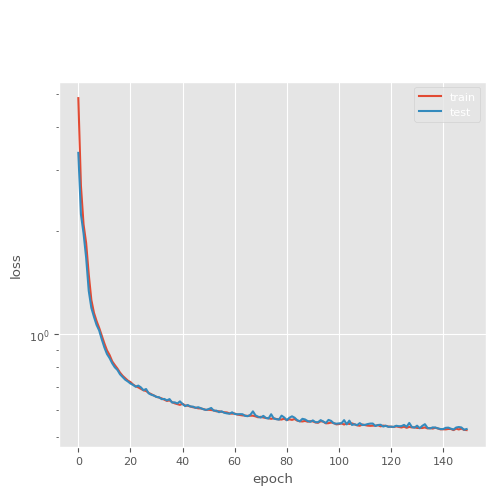

In [14]:
# # Plot the loss function
#dark background
plt.style.use('dark_background')
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#add tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#ggplot style
plt.style.use('ggplot')
plt.figure(figsize=(5,5))
#fontsize 16
plt.rcParams.update({'font.size': 8})
plt.plot(autoencoder.history.history['loss']) 
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss \n = encoder loss (L1 norm) + \n decoder loss (L2 norm) +\n end to end loss (L1 norm) ')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.yticks
# plt.xlim(-1,50)
plt.tight_layout()
plt.legend(['train', 'test'], loc='upper right')
#show tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.show()




In [15]:
WIDTH = HEIGHT = 1024

def encode(img):
    hsi_cube = np.asarray(img).reshape(-1,ENCODER_INPUT_DIM).astype('float32')
    # pred_maps = encoder.predict(hsi_cube)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder.predict_on_batch(hsi_cube)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        recovered = decoder.predict_on_batch(encoded)
        # recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = np.clip(recovered, 0, 1)
    
    return recovered, elapsed


vis_data shape (1024, 1024, 31)
nir_data shape (1024, 1024, 31)


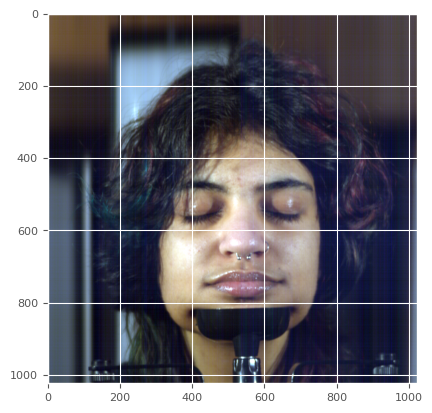

hsi_data shape (1024, 1024, 39)


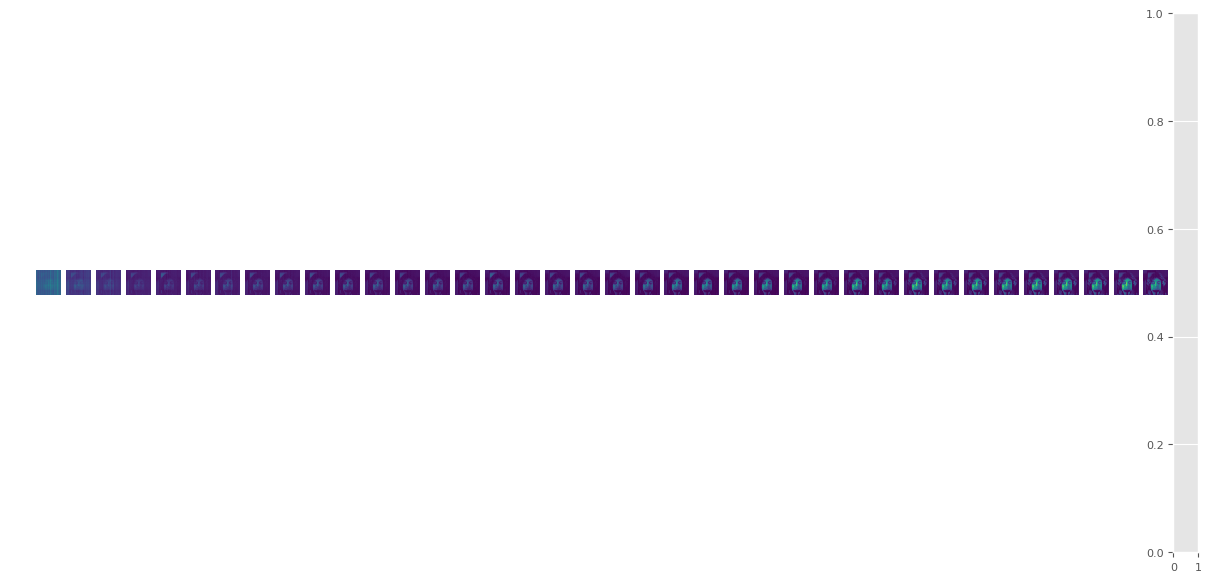

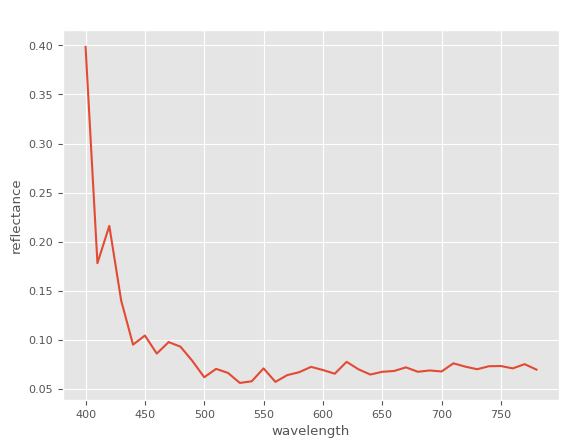

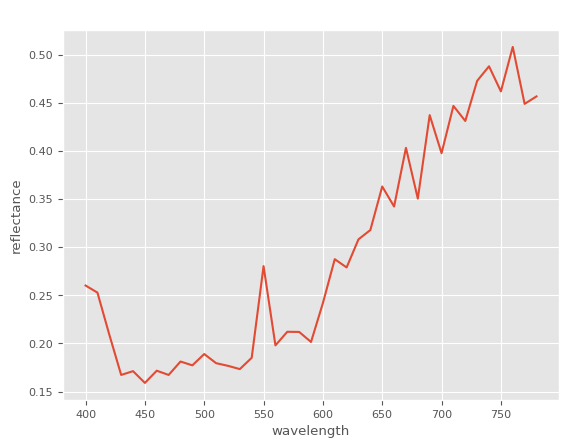

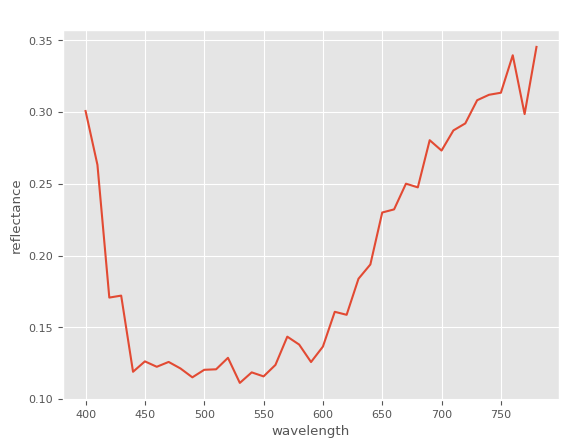

encoded shape (1048576, 5)


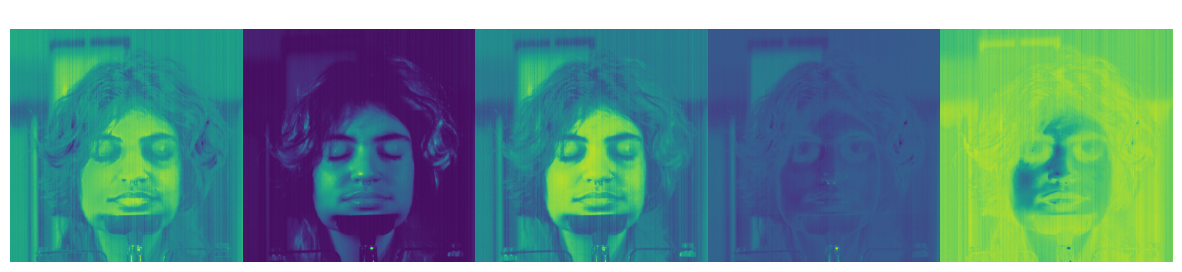

recovered shape (1048576, 39)


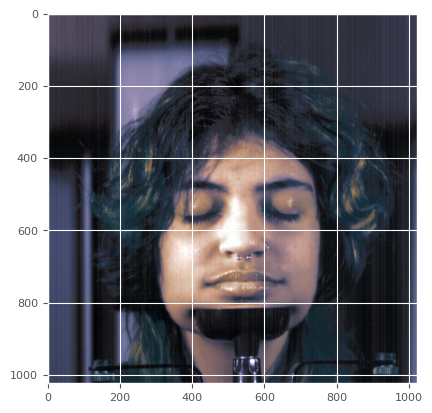

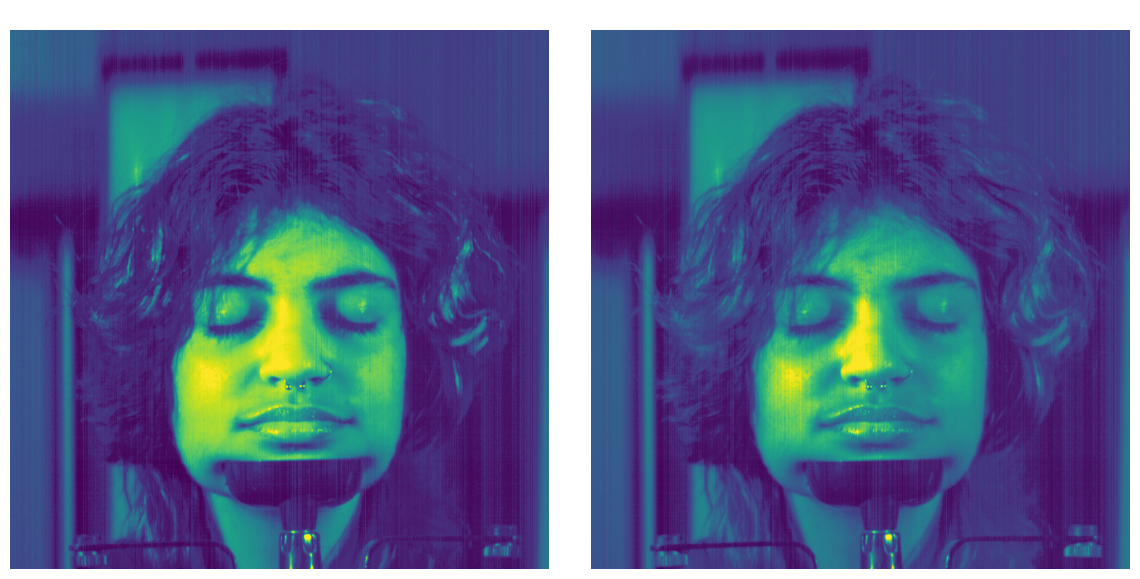

Cm min 0.11630542576313019 mean 0.32489699125289917 max 0.5582708716392517
Ch min -0.36062607169151306 mean 0.0038676592521369457 max 0.05043609440326691
Bm min 0.24555760622024536 mean 0.6344331502914429 max 0.9801761507987976
Bh min -0.5963249206542969 mean 0.03212268278002739 max 0.2673185169696808
T min 0.1692211627960205 mean 0.2454536408185959 max 0.5299842953681946


In [19]:
import time
import numpy as np
import mat73
import matplotlib.pyplot as plt
import cv2

# Constants
WIDTH = HEIGHT = 1024
wl_vis = np.linspace(400,700, 31)
wl_nir = np.linspace(710, 780, 8)
wavelengths = np.concatenate([wl_vis, wl_nir])

# Load data
vis_path = r"D:\HSI_DATASET\train_vis\VIS\p006_neutral_front.mat"
nir_path = r"D:\hsi\Hyper-Skin(MSI,NIR)\train\NIR\p006_neutral_front.mat"
# Print shapes
print(f"vis_data shape {vis_data.shape}")
print(f"nir_data shape {nir_data.shape}")

# Convert VIS data to RGB and display
vis_data_flat = np.reshape(vis_data, [-1, vis_data.shape[2]])
illuminant = 65
threshold = 0.002
rgb_image = HSI2RGB(wl_vis, vis_data_flat, vis_data.shape[1], vis_data.shape[0], illuminant, threshold)
plt.imshow(rgb_image)
plt.show()

# Stack VIS and NIR data
nir_data_selected = nir_data[:,:,1:9]
hsi_data = np.dstack((vis_data, nir_data_selected))
print(f"hsi_data shape {hsi_data.shape}")

# Display spectral bands as subplots
fig, axs = plt.subplots(nrows=1, ncols=len(wavelengths), figsize=(15,7))
for idx, wl in enumerate(wavelengths[:-1]):
    axs[idx].imshow(hsi_data[:,:,idx], cmap='viridis')
    axs[idx].set_title(f"{wl} nm")
    axs[idx].axis('off')
plt.show()

# Reflectance vs wavelength plot for 3 random pixels
rand_x = np.random.randint(5, hsi_data.shape[1], 3)
rand_y = np.random.randint(5, hsi_data.shape[0], 3)
for x, y in zip(rand_x, rand_y):
    plt.plot(wavelengths, hsi_data[y, x, :])
    plt.ylabel('reflectance')
    plt.xlabel('wavelength')
    plt.title(f"pixel ({x},{y})")
    plt.show()

# Resize HSI data
hsi_data_resized = cv2.resize(hsi_data, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)

# Encode and decode the HSI cube
encoded, elapsed = encode(hsi_data_resized)
print(f"encoded shape {encoded.shape}")

# Display parameter maps
headers = ["Header1", "Header2", "Header3", "Header4", "Header5"]  # Replace with actual headers
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,7))
fig.subplots_adjust(wspace=0)
for i, ax in enumerate(axs):
    ax.imshow(encoded[:, i].reshape((WIDTH,HEIGHT)), cmap='viridis_r')
    ax.set_title(headers[i])
    ax.axis('off')
plt.show()

# Decode and display recovered image
recovered, elapsed = decode(encoded)
print(f"recovered shape {recovered.shape}")
recovered_rgb = HSI2RGB(wl_vis, recovered[:,:31], WIDTH, HEIGHT, illuminant, threshold)
plt.imshow(recovered_rgb)
plt.show()

# Display Cm and Ch
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.subplots_adjust(wspace=0)
axs[0].imshow(recovered_rgb[:,:,0], cmap='viridis')
axs[0].set_title('Cm')
axs[1].imshow(recovered_rgb[:,:,1], cmap='viridis')
axs[1].set_title('Ch')
for ax in axs:
    ax.axis('off')
plt.show()

# Stats
encoded_reshaped = encoded.reshape((WIDTH, HEIGHT, 5))
params = ["Cm", "Ch", "Bm", "Bh", "T"]
for i, param in enumerate(params):
    print(f"{param} min {np.min(encoded_reshaped[:,:,i])} mean {np.mean(encoded_reshaped[:,:,i])} max {np.max(encoded_reshaped[:,:,i])}")

In [ ]:
directory_path =  my_config.LOCAL_SAVE 
#ask user for folder name
folder_name = input("Enter folder name: ")
directory_path = os.path.join(directory_path, folder_name)
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
# Saving the models as .pb files
# tf.saved_model.save(encoder, os.path.join(directory_path, 'encoder_pb'))
# tf.saved_model.save(decoder, os.path.join(directory_path, 'decoder_pb'))
# tf.saved_model.save(autoencoder, os.path.join(directory_path, 'autoencoder_pb'))
# Saving the models as .h5 files
encoder_path = directory_path + 'encoder.h5'
decoder_path = directory_path + 'decoder.h5'
autoencoder_path = directory_path + 'ae.h5'
encoder.save(encoder_path)
decoder.save(decoder_path)
autoencoder.save(autoencoder_path)


In [ ]:
# Ensure your model is in inference mode
encoder.trainable = False
decoder.trainable = False
input_shape_encoder = (None, 3)
input_shape_decoder = (None, 5)
# Alternatively, use the following to convert a model to inference mode
# encoder_model = tf.keras.models.clone_model(encoder, clone_function=lambda layer: layer if "dropout" not in layer.get_config().get("name", "").lower() else tf.keras.layers.Activation("linear")(layer.output))
# decoder_model = tf.keras.models.clone_model(decoder, clone_function=lambda layer: layer if "dropout" not in layer.get_config().get("name", "").lower() else tf.keras.layers.Activation("linear")(layer.output))
# Define the input signature
input_signature_encoder = [tf.TensorSpec(shape=[None, *input_shape_encoder], dtype=tf.float32)]
input_signature_decoder = [tf.TensorSpec(shape=[None, *input_shape_decoder], dtype=tf.float32)]

# Convert model call to a tf.function with the defined input signature
# encoder_func = tf.function(encoder_model.call).get_concrete_function(input_signature_encoder)
# decoder_func = tf.function(decoder_model.call).get_concrete_function(input_signature_decoder)

# Save the models with the specific signatures
tf.saved_model.save(encoder, "encoder_sep_19")
tf.saved_model.save(decoder, "decoder_sep_19")